<a href="https://colab.research.google.com/github/yeoun9/torchpm/blob/main/examples/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install git+https://github.com/yeoun9/torchpm.git
import torchpm as tcpm
import torch as tc
import numpy as np
import matplotlib.pyplot as plt

# Model Building

In [20]:
dataset_file_path = 'https://raw.githubusercontent.com/yeoun9/torchpm/main/examples/THEO.csv'
column_names = ['ID', 'AMT', 'TIME', 'DV', 'CMT', 'MDV', 'RATE', 'BWT']

device = tc.device("cuda:0" if tc.cuda.is_available() else "cpu")
dataset = tcpm.data.CSVDataset(dataset_file_path, column_names, device)

class PKParameter(tcpm.funcgen.PKParameterGenerator) :
    def __call__(self, theta, eta) :
        k_a = theta[0]*tc.exp(eta[0])
        v = theta[1]*tc.exp(eta[1])
        k_e = theta[2]*tc.exp(eta[2])
        return {'k_a': k_a, 'v' : v, 'k_e': k_e}
pk_parameter = PKParameter()

class PredFunction(tcpm.funcgen.PredFunctionGenerator) :
    def __call__(self, t, y, theta, eta, cmt, amt, rate, pk, bwt, tmpcov) :
        k_a = pk['k_a']
        v = pk['v']
        k = pk['k_e']
        return (320 / v * k_a) / (k_a - k) * (tc.exp(-k*t) - tc.exp(-k_a*t))
pred_fn = PredFunction()


class ErrorFunction(tcpm.funcgen.ErrorFunctionGenerator):
    def __call__(self, y_pred, eps, theta, eta, cmt, pk, bwt, tmpcov) :
        return y_pred +  y_pred * eps[0]  + eps[1]

error_fn = ErrorFunction()

theta_size = 3
theta_init = tc.tensor([ 1.5, 30,  0.1], device=device)
theta_lower_boundary  = tc.tensor([0.,0.,0.], device = device)
theta_upper_boundary  = tc.tensor([10,100,10], device = device)
theta_scale = tcpm.scale.ScaledVector(theta_init, lower_boundary = theta_lower_boundary, upper_boundary = theta_upper_boundary)
theta_init = tc.tensor([ 0.1, 0.1,  0.1], device=device)



eta_size = 3
omega_init = [tc.tensor([0.2,
                        0.1, 0.2,
                        0.1, 0.1, 0.2], device = device)]
omega_diagonals = [False]
omega_scales = [tcpm.scale.ScaledMatrix(omega_init[0], omega_diagonals[0])]
omega_inits = [tc.tensor([ 0.1,
                        0.1,  0.1,
                        0.1,  0.1,  0.1], device = device)]

eps_size = 2
sigma_init = [tc.tensor([0.2, 0.1], device = device)]
sigma_diagonals = [True]
sigma_scales = [tcpm.scale.ScaledMatrix(sigma_init[0], sigma_diagonals[0])]
sigma_inits = [tc.tensor([0.1, 0.1], device = device)]



pred_function_module = tcpm.predfunction.PredictionFunctionByTime(dataset = dataset,
                                                column_names = column_names,
                                                theta_size = theta_size,
                                                eta_size = eta_size,
                                                eps_size = eps_size,
                                                pk_parameter = pk_parameter,
                                                pred_fn  = pred_fn,
                                                error_fn = error_fn,
                                                theta_scale = theta_scale)

differential_module = tcpm.diff.DifferentialModule(omega_diagonals = omega_diagonals,
                                         sigma_diagonals = sigma_diagonals,
                                         omega_scales = omega_scales,
                                         sigma_scales = sigma_scales)

model = tcpm.model.FOCEInter(pred_function_module, differential_module)

model.pred_function_module.theta = tc.nn.Parameter(theta_init)
model.differential_module.sigma = tc.nn.ParameterList([tc.nn.Parameter(tensor) for tensor in sigma_inits])
model.differential_module.omega = tc.nn.ParameterList([tc.nn.Parameter(tensor) for tensor in omega_inits])
model = model.to(device)

#Model Fitting

In [21]:
model.fit_population(learning_rate = 1, tolerance_grad = 1e-3, tolerance_change= 1e-3)

running_time :  0.1960141658782959 	 total_loss: tensor(294.3966, grad_fn=<AddBackward0>)
running_time :  0.3752872943878174 	 total_loss: tensor(284.7472, grad_fn=<AddBackward0>)
running_time :  0.5702857971191406 	 total_loss: tensor(258.7735, grad_fn=<AddBackward0>)
running_time :  0.752995491027832 	 total_loss: tensor(305.4727, grad_fn=<AddBackward0>)
running_time :  0.9403369426727295 	 total_loss: tensor(224.8356, grad_fn=<AddBackward0>)
running_time :  1.1501741409301758 	 total_loss: tensor(210.7302, grad_fn=<AddBackward0>)
running_time :  1.3368630409240723 	 total_loss: tensor(189.2910, grad_fn=<AddBackward0>)
running_time :  1.5669283866882324 	 total_loss: tensor(177.5394, grad_fn=<AddBackward0>)
running_time :  1.7560248374938965 	 total_loss: tensor(164.4704, grad_fn=<AddBackward0>)
running_time :  1.9537701606750488 	 total_loss: tensor(153.6986, grad_fn=<AddBackward0>)
running_time :  2.1533756256103516 	 total_loss: tensor(140.6750, grad_fn=<AddBackward0>)
running_tim

# Result

time-pred


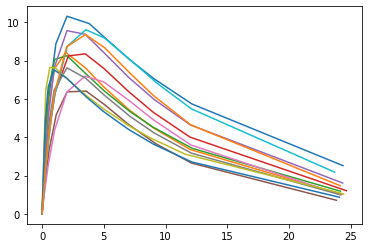

time-cwres


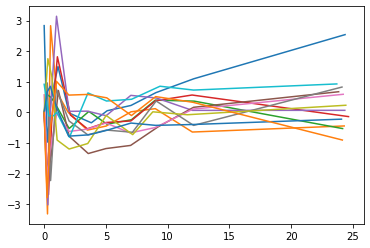

In [22]:
eval_result = model.evaluate()

print('time-pred')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for id, time_data in eval_result['times'].items() :
    y_pred = eval_result['preds'][id]
    ax.plot(time_data.to('cpu'), y_pred.detach().to('cpu').numpy())
plt.show()

print('time-cwres')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for id, time_data in eval_result['times'].items() :
    cwres_value = eval_result['cwress'][id]
    ax.plot(time_data.masked_select(eval_result['mdv_masks'][id]).to('cpu'), cwres_value.detach().to('cpu').numpy())
plt.show()

In [23]:
for k, v in eval_result.items():
    print(k)
    print(v)

total_loss
tensor(101.5706)
losses
{'1': 22.47138214111328, '2': 18.38483238220215, '3': -0.5275068283081055, '4': 9.827661514282227, '5': 20.444679260253906, '6': 5.179571151733398, '7': 2.472097396850586, '8': 4.451855659484863, '9': 4.16536808013916, '10': 5.411951065063477, '11': -1.4783191680908203, '12': 10.767019271850586}
times
{'1': tensor([ 0.0000,  0.0000,  0.2500,  0.5700,  1.1200,  2.0200,  3.8200,  5.1000,
         7.0300,  9.0500, 12.1200, 24.3700]), '2': tensor([ 0.0000,  0.0000,  0.2700,  0.5200,  1.0000,  1.9200,  3.5000,  5.0200,
         7.0300,  9.0000, 12.0000, 24.3000]), '3': tensor([ 0.0000,  0.0000,  0.2700,  0.5800,  1.0200,  2.0200,  3.6200,  5.0800,
         7.0700,  9.0000, 12.1500, 24.1700]), '4': tensor([ 0.0000,  0.0000,  0.3500,  0.6000,  1.0700,  2.1300,  3.5000,  5.0200,
         7.0200,  9.0200, 11.9800, 24.6500]), '5': tensor([ 0.0000,  0.0000,  0.3000,  0.5200,  1.0000,  2.0200,  3.5000,  5.0200,
         7.0200,  9.1000, 12.0000, 24.3500]), '6': t

In [24]:
cov_result = model.descale().covariance_step()
print(cov_result)

id 1
id 2
id 3
id 4
id 5
id 6
id 7
id 8
id 9
id 10
id 11
id 12
{'cov': tensor([[ 2.3916e-03, -2.0612e-03, -6.4713e-05,  2.5911e-03,  3.9930e-04,
          7.4737e-05,  6.9464e-05,  1.9165e-04,  3.4473e-04, -5.4934e-04,
          2.8838e-03],
        [ 2.7531e-02,  1.9976e-01, -1.3193e-03,  1.3498e-02, -1.4951e-03,
         -1.5404e-04, -5.2458e-04,  2.3548e-03,  3.2026e-03, -4.2460e-03,
          1.9814e-02],
        [-1.2007e-04, -7.5606e-04,  5.5762e-06, -3.0150e-05,  7.0398e-06,
          3.3351e-07, -2.5326e-06, -1.0960e-05, -1.5322e-05,  1.8690e-05,
         -9.9577e-05],
        [ 5.3898e-04, -2.2064e-03,  8.3419e-06,  2.5954e-02,  4.1492e-03,
          4.3222e-04, -1.0574e-03, -3.3034e-04, -4.2504e-04, -2.3254e-04,
         -2.2149e-03],
        [-3.3157e-05, -5.0812e-03,  1.5455e-05,  4.1478e-03,  8.7523e-04,
          1.1114e-04,  2.1781e-05, -5.8258e-05, -9.6319e-05, -4.8250e-05,
         -2.9000e-04],
        [ 7.4177e-06, -1.0883e-03,  2.6671e-06,  4.3235e-04,  1.1094e-04,


In [25]:
for (name, para) in model.named_parameters():
    print(name)
    print(para.detach().numpy())

pred_function_module.theta
[ 1.3086255  30.834517    0.09107856]
pred_function_module.etas.1
[-0.03648025 -0.16870779 -0.3029844 ]
pred_function_module.etas.2
[0.18957716 0.02570093 0.06451488]
pred_function_module.etas.3
[ 0.5076693   0.07709336 -0.03090253]
pred_function_module.etas.4
[-0.40125838 -0.06652414  0.03680788]
pred_function_module.etas.5
[-0.16386452 -0.14585498 -0.05992061]
pred_function_module.etas.6
[-0.4314881   0.14918351  0.20748901]
pred_function_module.etas.7
[-0.83593875 -0.01947387  0.15586336]
pred_function_module.etas.8
[0.02974866 0.10694635 0.04498723]
pred_function_module.etas.9
[ 1.4024122   0.22994556 -0.06590898]
pred_function_module.etas.10
[-0.63225704 -0.20346569 -0.13487895]
pred_function_module.etas.11
[0.9591697  0.21914539 0.04174309]
pred_function_module.etas.12
[-0.5766253  -0.20370048  0.0432798 ]
pred_function_module.epss.1
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
pred_functio

#Simulation

id 1


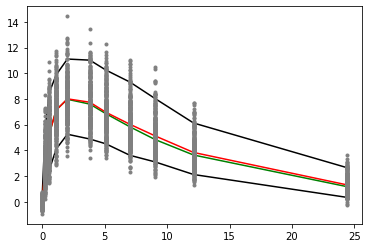

id 2


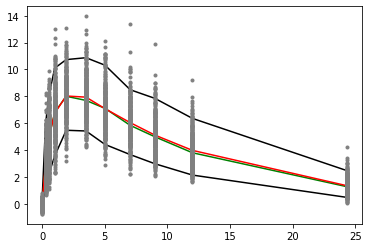

id 3


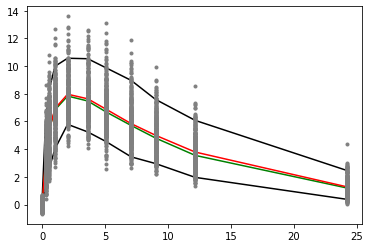

id 4


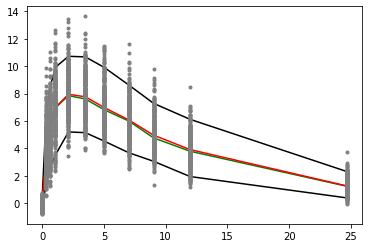

id 5


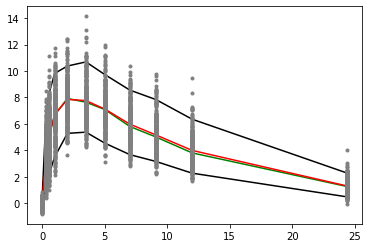

id 6


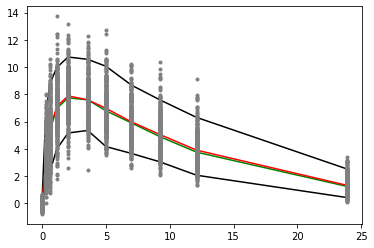

id 7


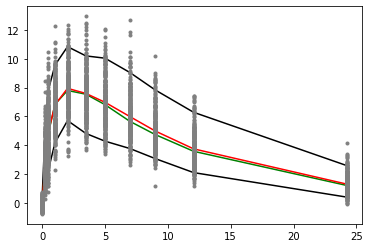

id 8


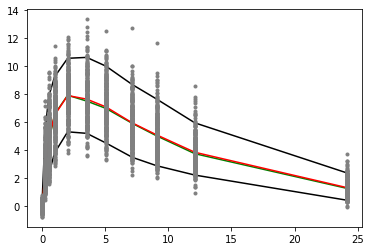

id 9


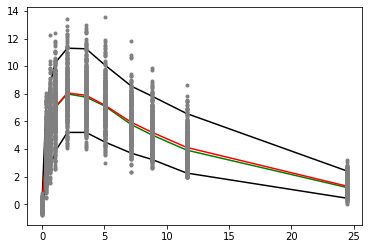

id 10


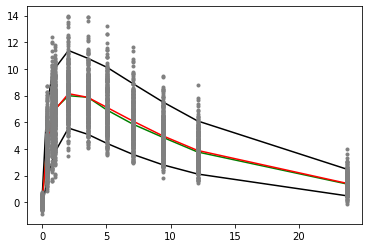

id 11


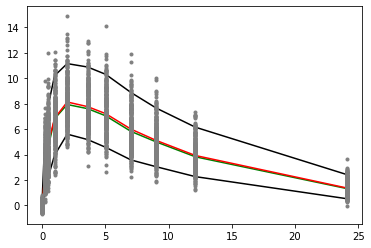

id 12


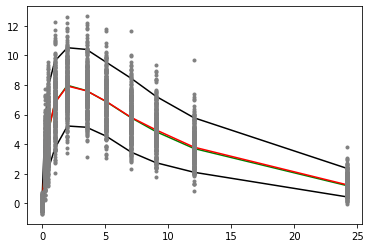

In [26]:
tc.manual_seed(42)
simulation_result = model.simulate(dataset, 300)

for id, time_data in simulation_result['times'].items() :
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    print('id', id)
    
    p95 = np.percentile(tc.stack(simulation_result['preds'][id]), 95, 0)
    p50 = np.percentile(tc.stack(simulation_result['preds'][id]), 50, 0)
    average = np.average(tc.stack(simulation_result['preds'][id]), 0)
    p5 = np.percentile(tc.stack(simulation_result['preds'][id]), 5, 0)
    
    ax.plot(time_data.to('cpu'), p95, color="black")
    ax.plot(time_data.to('cpu'), p50, color="green")
    ax.plot(time_data.to('cpu'), average, color="red")
    ax.plot(time_data.to('cpu'), p5, color="black")
    
    for y_pred in simulation_result['preds'][id] :
        ax.plot(time_data.to('cpu'), y_pred.detach().to('cpu'), marker='.', linestyle='', color='gray')
    plt.show()